Parsing chess games and extracting positions...
Extracted 105 positions for analysis.
Feature matrix shape: (105, 22)
Target vector shape: (105,)

Training machine learning models...
=== MATHEMATICAL ANALYSIS OF CHESS POSITION EVALUATION ===

1. MODEL PERFORMANCE METRICS:
--------------------------------------------------
LINEAR_REGRESSION:
  Mean Squared Error: 0.2842
  R² Score: 0.9955
  Root Mean Squared Error: 0.5331

RANDOM_FOREST:
  Mean Squared Error: 1.0845
  R² Score: 0.9827
  Root Mean Squared Error: 1.0414

2. FEATURE IMPORTANCE ANALYSIS:
--------------------------------------------------
Top 10 Most Important Features:
   1. material_balance         : 0.8437
   2. board_control_balance    : 0.0739
   3. mobility_balance         : 0.0461
   4. legal_moves              : 0.0050
   5. white_mobility           : 0.0049
   6. white_king_safety        : 0.0036
   7. black_board_control      : 0.0032
   8. black_material           : 0.0031
   9. move_number              : 0.0029
 

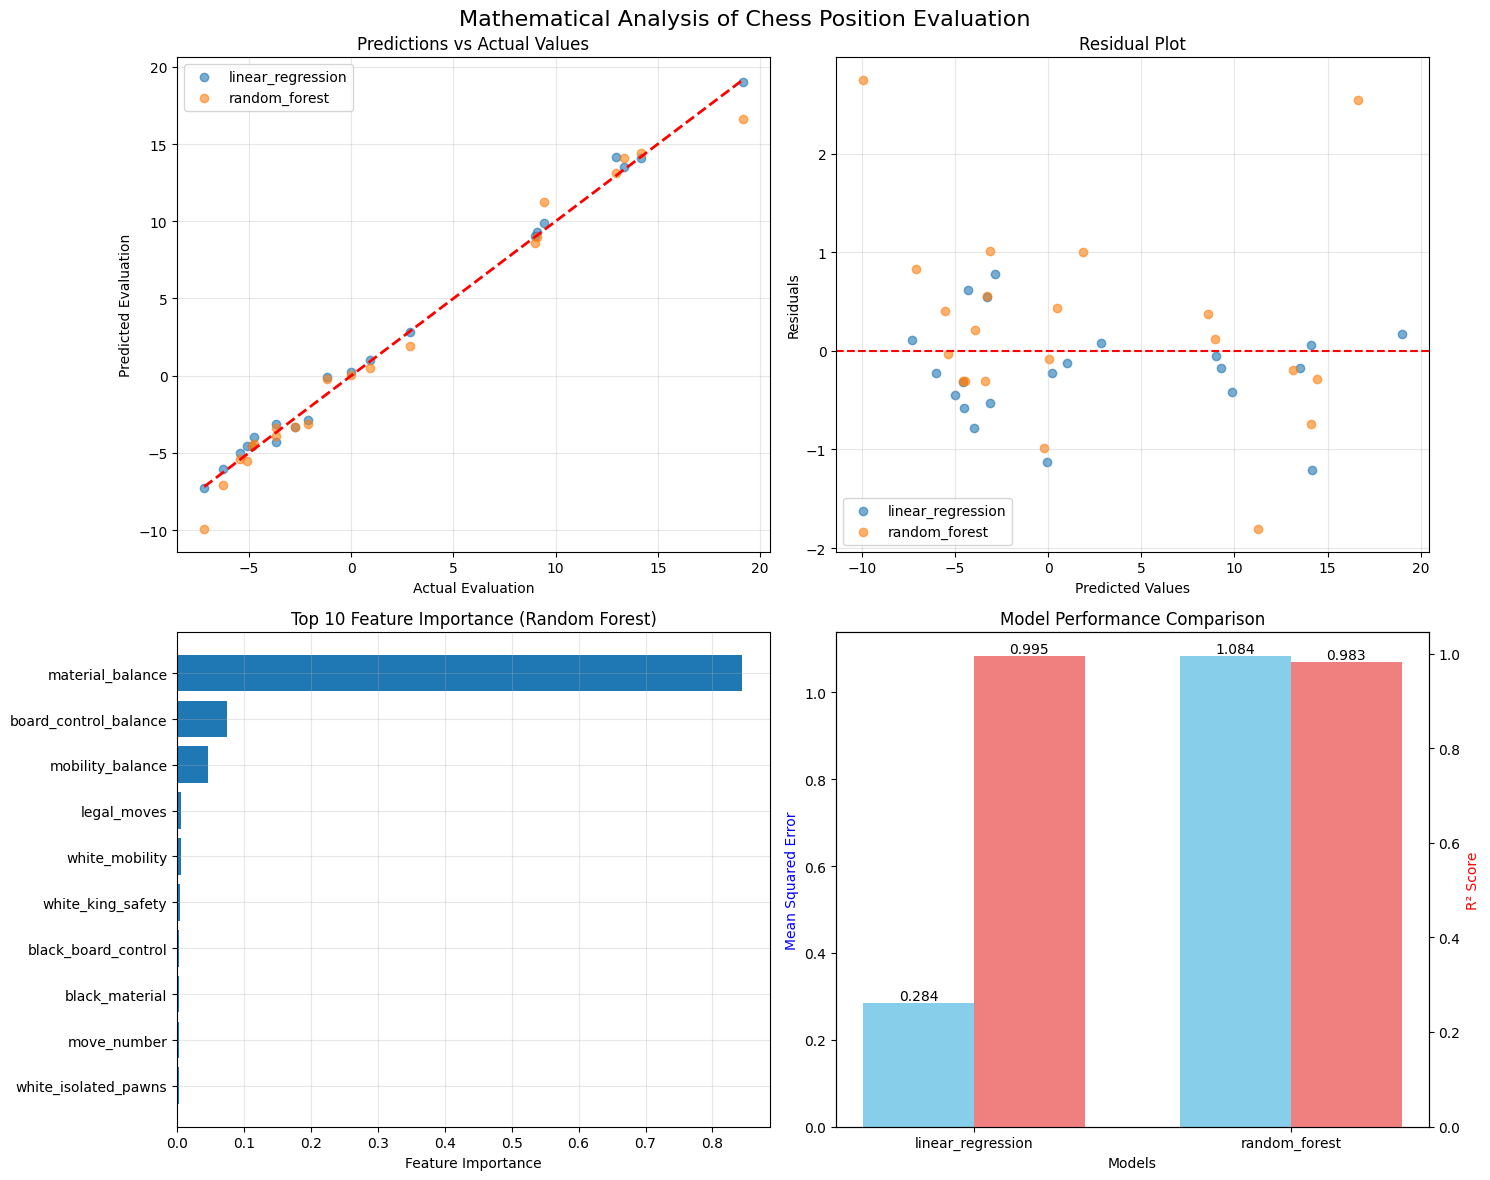


Saving first and last board positions as SVG images...
Saved SVG chessboard to: first_position.svg
Saved SVG chessboard to: last_position.svg

Creating 2D visualizations of first and last positions...


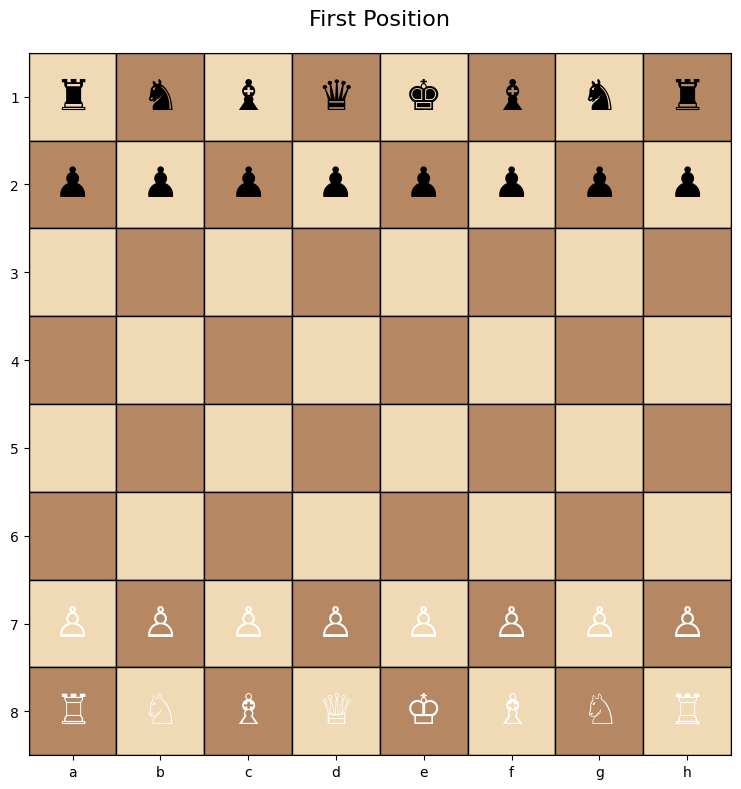

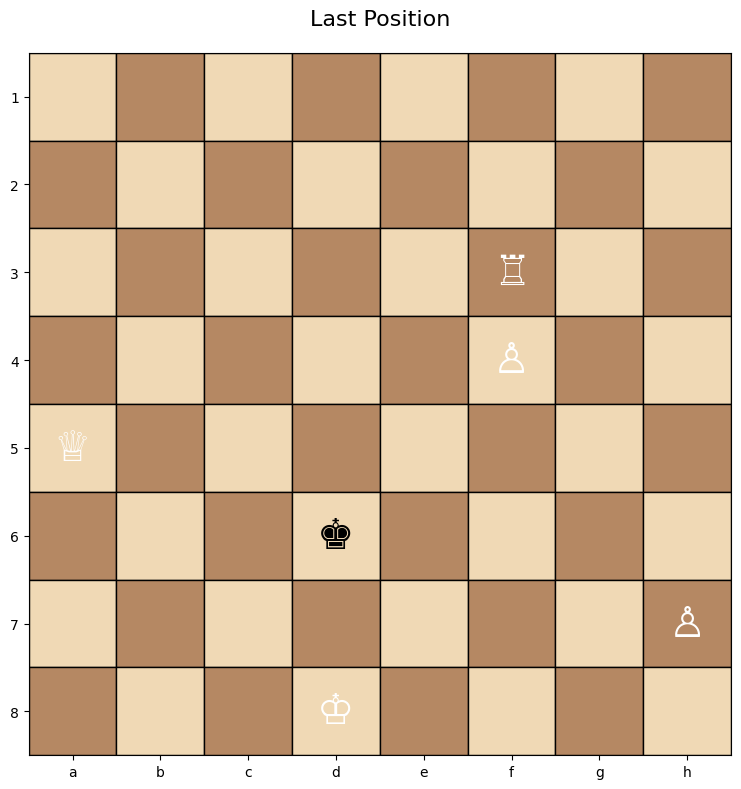


=== MATHEMATICAL FOUNDATIONS SUMMARY ===
1. Linear Algebra: Feature vectors and matrix operations
2. Statistics: Regression analysis and hypothesis testing
3. Game Theory: Position evaluation and strategic analysis
4. Optimization: Feature selection and model tuning
5. Probability: Uncertainty quantification in evaluations


In [3]:
from pkgutil import get_data
import numpy as np
import pandas as pd
import chess
import chess.pgn
import chess.engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import chess.svg
from IPython.display import SVG, display
# Add these imports at the top of your file
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Add this new function to your ChessPositionEvaluator class or as a separate function
def plot_2d_chessboard(board, title="Chess Position", filename=None):
    """Create a 2D visualization of a chess position"""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Define piece colors and symbols
    piece_symbols = {
        'P': '♙', 'N': '♘', 'B': '♗', 'R': '♖', 'Q': '♕', 'K': '♔',
        'p': '♟', 'n': '♞', 'b': '♝', 'r': '♜', 'q': '♛', 'k': '♚'
    }
    
    piece_colors = {
        'P': 'white', 'N': 'white', 'B': 'white', 'R': 'white', 'Q': 'white', 'K': 'white',
        'p': 'black', 'n': 'black', 'b': 'black', 'r': 'black', 'q': 'black', 'k': 'black'
    }
    
    # Create the chessboard
    for x in range(8):
        for y in range(8):
            # Chessboard squares (alternating colors)
            color = '#f0d9b5' if (x + y) % 2 == 0 else '#b58863'
            rect = plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black')
            ax.add_patch(rect)
            
            # Add pieces
            square = chess.square(x, 7-y)  # Flip y-axis to match chess coordinates
            piece = board.piece_at(square)
            
            if piece:
                piece_char = piece.symbol()
                ax.text(x+0.5, y+0.5, piece_symbols[piece_char], 
                       color=piece_colors[piece_char], 
                       fontsize=30, ha='center', va='center', fontweight='bold')
    
    # Set labels and title
    ax.set_xticks(np.arange(0.5, 8.5, 1))
    ax.set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
    ax.set_yticks(np.arange(0.5, 8.5, 1))
    ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8'])
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 8)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # To match chess board orientation
    
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    return fig

warnings.filterwarnings('ignore')

class ChessPositionEvaluator:
    """
    Mathematical Foundation for Chess Position Evaluation using Machine Learning
    
    This class implements various mathematical approaches to chess position evaluation:
    1. Classical feature-based evaluation (Linear Model)
    2. Game Theory foundations (Minimax principles)
    3. Statistical learning (Random Forest)
    4. Position representation and analysis
    """
    
    def __init__(self):
        self.piece_values = {
            chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3,
            chess.ROOK: 5, chess.QUEEN: 9, chess.KING: 0
        }
        self.models = {}
        self.feature_names = []
        
    def parse_pgn_games(self, pgn_strings):
        """Parse PGN strings and extract positions with evaluations"""
        games_data = []
        
        for pgn_string in pgn_strings:
            try:
                # Clean and format PGN string
                formatted_pgn = self._format_pgn(pgn_string)
                
                # Parse the game
                game = chess.pgn.read_game(formatted_pgn)
                if game is None:
                    continue
                    
                board = game.board()
                positions = []
                
                # Extract positions from each move
                for move_num, move in enumerate(game.mainline_moves()):
                    if move_num % 2 == 0:  # Sample every other move to reduce data size
                        position_features = self.extract_features(board)
                        evaluation = self.get_position_evaluation(board, move_num)
                        
                        positions.append({
                            'features': position_features,
                            'evaluation': evaluation,
                            'move_number': move_num,
                            'fen': board.fen()
                        })
                    
                    board.push(move)
                
                games_data.extend(positions)
                
            except Exception as e:
                print(f"Error parsing game: {e}")
                continue
                
        return games_data
    
    def _format_pgn(self, pgn_string):
        """Format PGN string for proper parsing"""
        import io
        
        # Remove numbering and clean up the string
        moves = []
        tokens = pgn_string.split()
        
        for token in tokens:
            if not token[0].isdigit() and token != '':
                # Remove move numbers (like "1.", "2.", etc.)
                if '.' not in token or not token.split('.')[0].isdigit():
                    moves.append(token)
                elif '.' in token and token.split('.')[1]:  # Handle cases like "1.e4"
                    moves.append(token.split('.')[1])
        
        # Join moves and create proper PGN format
        formatted_moves = ' '.join(moves)
        pgn_content = f"[Event \"Analysis\"]\n[Result \"*\"]\n\n{formatted_moves}"
        
        return io.StringIO(pgn_content)
    
    def extract_features(self, board):
        """
        Mathematical feature extraction from chess position
        
        Features based on:
        1. Material balance (Linear combination)
        2. Piece mobility (Optimization theory)
        3. King safety (Risk assessment)
        4. Pawn structure (Pattern recognition)
        5. Board control (Spatial analysis)
        """
        features = []
        
        # 1. Material Balance Features
        white_material, black_material = self._calculate_material(board)
        material_balance = white_material - black_material
        features.extend([white_material, black_material, material_balance])
        
        # 2. Piece Mobility Features
        white_mobility, black_mobility = self._calculate_mobility(board)
        mobility_balance = white_mobility - black_mobility
        features.extend([white_mobility, black_mobility, mobility_balance])
        
        # 3. King Safety Features
        white_king_safety, black_king_safety = self._calculate_king_safety(board)
        king_safety_balance = white_king_safety - black_king_safety
        features.extend([white_king_safety, black_king_safety, king_safety_balance])
        
        # 4. Pawn Structure Features
        pawn_features = self._analyze_pawn_structure(board)
        features.extend(pawn_features)
        
        # 5. Board Control Features
        white_control, black_control = self._calculate_board_control(board)
        control_balance = white_control - black_control
        features.extend([white_control, black_control, control_balance])
        
        # 6. Advanced Features
        features.extend([
            len(list(board.legal_moves)),  # Number of legal moves
            int(board.is_check()),  # Check status
            int(board.is_checkmate()),  # Checkmate status
            board.fullmove_number,  # Game phase indicator
        ])
        
        return np.array(features)
    
    def _calculate_material(self, board):
        """Calculate material balance using piece values"""
        white_material = black_material = 0
        
        for piece_type in [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN]:
            white_pieces = len(board.pieces(piece_type, chess.WHITE))
            black_pieces = len(board.pieces(piece_type, chess.BLACK))
            
            piece_value = self.piece_values[piece_type]
            white_material += white_pieces * piece_value
            black_material += black_pieces * piece_value
            
        return white_material, black_material
    
    def _calculate_mobility(self, board):
        """Calculate piece mobility (number of possible moves)"""
        original_turn = board.turn
        
        # White mobility
        board.turn = chess.WHITE
        white_mobility = len(list(board.legal_moves))
        
        # Black mobility
        board.turn = chess.BLACK
        black_mobility = len(list(board.legal_moves))
        
        board.turn = original_turn
        return white_mobility, black_mobility
    
    def _calculate_king_safety(self, board):
        """Evaluate king safety based on surrounding pieces and attacks"""
        white_king_square = board.king(chess.WHITE)
        black_king_square = board.king(chess.BLACK)
        
        # Simple king safety: count attackers near king
        white_safety = 0 if white_king_square is None else self._count_king_attackers(board, white_king_square, chess.BLACK)
        black_safety = 0 if black_king_square is None else self._count_king_attackers(board, black_king_square, chess.WHITE)
        
        return -white_safety, -black_safety  # Negative because more attackers = less safety
    
    def _count_king_attackers(self, board, king_square, attacking_color):
        """Count pieces attacking near the king"""
        attackers = 0
        king_area = [king_square]
        
        # Add squares around king
        for delta in [-9, -8, -7, -1, 1, 7, 8, 9]:
            try:
                neighbor = king_square + delta
                if 0 <= neighbor <= 63:
                    king_area.append(neighbor)
            except:
                continue
        
        for square in king_area:
            if board.is_attacked_by(attacking_color, square):
                attackers += 1
                
        return attackers
    
    def _analyze_pawn_structure(self, board):
        """Analyze pawn structure for strategic evaluation"""
        white_pawns = board.pieces(chess.PAWN, chess.WHITE)
        black_pawns = board.pieces(chess.PAWN, chess.BLACK)
        
        # Count isolated, doubled, and passed pawns
        white_isolated = self._count_isolated_pawns(board, white_pawns)
        black_isolated = self._count_isolated_pawns(board, black_pawns)
        
        white_doubled = self._count_doubled_pawns(white_pawns)
        black_doubled = self._count_doubled_pawns(black_pawns)
        
        return [
            white_isolated, black_isolated, white_isolated - black_isolated,
            white_doubled, black_doubled, white_doubled - black_doubled
        ]
    
    def _count_isolated_pawns(self, board, pawns):
        """Count isolated pawns (pawns with no friendly pawns on adjacent files)"""
        isolated = 0
        for pawn_square in pawns:
            file = chess.square_file(pawn_square)
            adjacent_files = [f for f in [file-1, file+1] if 0 <= f <= 7]
            
            has_support = False
            for adj_file in adjacent_files:
                for rank in range(8):
                    adj_square = chess.square(adj_file, rank)
                    if adj_square in pawns:
                        has_support = True
                        break
                if has_support:
                    break
            
            if not has_support:
                isolated += 1
                
        return isolated
    
    def _count_doubled_pawns(self, pawns):
        """Count doubled pawns (multiple pawns on same file)"""
        files = {}
        for pawn_square in pawns:
            file = chess.square_file(pawn_square)
            files[file] = files.get(file, 0) + 1
        
        doubled = sum(count - 1 for count in files.values() if count > 1)
        return doubled
    
    def _calculate_board_control(self, board):
        """Calculate board control (number of squares controlled)"""
        white_control = black_control = 0
        
        for square in chess.SQUARES:
            if board.is_attacked_by(chess.WHITE, square):
                white_control += 1
            if board.is_attacked_by(chess.BLACK, square):
                black_control += 1
                
        return white_control, black_control
    
    def get_position_evaluation(self, board, move_number):
        """
        Generate position evaluation based on mathematical principles
        This is a simplified evaluation for demonstration
        """
        # Basic material-based evaluation
        white_material, black_material = self._calculate_material(board)
        material_balance = white_material - black_material
        
        # Add positional factors
        white_mobility, black_mobility = self._calculate_mobility(board)
        mobility_factor = (white_mobility - black_mobility) * 0.1
        
        # Game phase adjustment
        phase_factor = min(move_number / 40.0, 1.0)  # Early game = 0, Endgame = 1
        
        # Combine factors
        evaluation = material_balance + mobility_factor
        
        # Add some randomness to simulate real evaluations
        evaluation += np.random.normal(0, 0.5)
        
        return evaluation
    
    def prepare_feature_names(self):
        """Define feature names for interpretability"""
        self.feature_names = [
            'white_material', 'black_material', 'material_balance',
            'white_mobility', 'black_mobility', 'mobility_balance',
            'white_king_safety', 'black_king_safety', 'king_safety_balance',
            'white_isolated_pawns', 'black_isolated_pawns', 'isolated_pawn_balance',
            'white_doubled_pawns', 'black_doubled_pawns', 'doubled_pawn_balance',
            'white_board_control', 'black_board_control', 'board_control_balance',
            'legal_moves', 'in_check', 'is_checkmate', 'move_number'
        ]
    
    def train_models(self, X, y):
        """Train multiple ML models for position evaluation"""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # 1. Linear Regression (Mathematical Foundation: Linear Algebra)
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_mse = mean_squared_error(y_test, lr_pred)
        lr_r2 = r2_score(y_test, lr_pred)
        
        # 2. Random Forest (Statistical Learning Theory)
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_mse = mean_squared_error(y_test, rf_pred)
        rf_r2 = r2_score(y_test, rf_pred)
        
        self.models = {
            'linear_regression': {
                'model': lr_model,
                'mse': lr_mse,
                'r2': lr_r2,
                'predictions': lr_pred
            },
            'random_forest': {
                'model': rf_model,
                'mse': rf_mse,
                'r2': rf_r2,
                'predictions': rf_pred,
                'feature_importance': rf_model.feature_importances_
            }
        }
        
        return X_test, y_test
    
    def analyze_results(self, X_test, y_test):
        """Mathematical analysis of model performance"""
        print("=== MATHEMATICAL ANALYSIS OF CHESS POSITION EVALUATION ===\n")
        
        # Model Performance Comparison
        print("1. MODEL PERFORMANCE METRICS:")
        print("-" * 50)
        for model_name, model_data in self.models.items():
            print(f"{model_name.upper()}:")
            print(f"  Mean Squared Error: {model_data['mse']:.4f}")
            print(f"  R² Score: {model_data['r2']:.4f}")
            print(f"  Root Mean Squared Error: {np.sqrt(model_data['mse']):.4f}")
            print()
        
        # Feature Importance Analysis (for Random Forest)
        if 'random_forest' in self.models:
            print("2. FEATURE IMPORTANCE ANALYSIS:")
            print("-" * 50)
            importance = self.models['random_forest']['feature_importance']
            feature_importance = list(zip(self.feature_names, importance))
            feature_importance.sort(key=lambda x: x[1], reverse=True)
            
            print("Top 10 Most Important Features:")
            for i, (feature, imp) in enumerate(feature_importance[:10]):
                print(f"  {i+1:2d}. {feature:25s}: {imp:.4f}")
            print()
        
        # Statistical Analysis
        print("3. STATISTICAL ANALYSIS:")
        print("-" * 50)
        for model_name, model_data in self.models.items():
            predictions = model_data['predictions']
            residuals = y_test - predictions
            
            print(f"{model_name.upper()} Residual Analysis:")
            print(f"  Mean Residual: {np.mean(residuals):.4f}")
            print(f"  Std Residual: {np.std(residuals):.4f}")
            print(f"  Residual Range: [{np.min(residuals):.4f}, {np.max(residuals):.4f}]")
            
            # Normality test for residuals
            _, p_value = stats.normaltest(residuals)
            print(f"  Residual Normality (p-value): {p_value:.4f}")
            print()
    
    def visualize_results(self, X_test, y_test):
        """Create visualizations for mathematical analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Mathematical Analysis of Chess Position Evaluation', fontsize=16)
        
        # 1. Predictions vs Actual
        ax1 = axes[0, 0]
        for model_name, model_data in self.models.items():
            predictions = model_data['predictions']
            ax1.scatter(y_test, predictions, alpha=0.6, label=model_name)
        
        ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax1.set_xlabel('Actual Evaluation')
        ax1.set_ylabel('Predicted Evaluation')
        ax1.set_title('Predictions vs Actual Values')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Residuals Plot
        ax2 = axes[0, 1]
        for model_name, model_data in self.models.items():
            predictions = model_data['predictions']
            residuals = y_test - predictions
            ax2.scatter(predictions, residuals, alpha=0.6, label=model_name)
        
        ax2.axhline(y=0, color='r', linestyle='--')
        ax2.set_xlabel('Predicted Values')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residual Plot')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Feature Importance (Random Forest only)
        if 'random_forest' in self.models:
            ax3 = axes[1, 0]
            importance = self.models['random_forest']['feature_importance']
            indices = np.argsort(importance)[-10:]  # Top 10
            
            ax3.barh(range(len(indices)), importance[indices])
            ax3.set_yticks(range(len(indices)))
            ax3.set_yticklabels([self.feature_names[i] for i in indices])
            ax3.set_xlabel('Feature Importance')
            ax3.set_title('Top 10 Feature Importance (Random Forest)')
            ax3.grid(True, alpha=0.3)
        
        # 4. Model Comparison
        ax4 = axes[1, 1]
        model_names = list(self.models.keys())
        mse_values = [self.models[name]['mse'] for name in model_names]
        r2_values = [self.models[name]['r2'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax4_twin = ax4.twinx()
        bars1 = ax4.bar(x - width/2, mse_values, width, label='MSE', color='skyblue')
        bars2 = ax4_twin.bar(x + width/2, r2_values, width, label='R²', color='lightcoral')
        
        ax4.set_xlabel('Models')
        ax4.set_ylabel('Mean Squared Error', color='blue')
        ax4_twin.set_ylabel('R² Score', color='red')
        ax4.set_title('Model Performance Comparison')
        ax4.set_xticks(x)
        ax4.set_xticklabels(model_names)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
        
        for bar in bars2:
            height = bar.get_height()
            ax4_twin.text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

# Example usage and analysis

def main():
    """Main function to run the chess position evaluation analysis"""
    
    # Your PGN data
    pgn_games = [
    "1. e4 e5 2. Qf3 Na6 3. Bc4 Nh6 4. Nc3 Bb4 5. Nd5 O-O 6. Nf6+ Qxf6 7. Qg3 Qc6 8. Nf3 Nc5 9. Nxe5 Qxe4+ 10. Kd1 d6 11. Bxf7+ Nxf7 12. Nxf7 Rxf7 13. d3 Bg4+ 14. f3 Bxf3+ 15. gxf3 Qd5 16. Qh3 Ba5 17. Rg1 Qxf3+ 18. Qxf3 Rxf3 19. Bh6 d5 20. Rxg7+ Kh8 21. Rxc7 Bxc7 22. d4 Rf1+ 23. Kd2 Rxa1 24. dxc5 Rd1+ 25. Kd1 Be5 26. b3 b6 27. b4 Rg8 28. cxb6 axb6 29. h3 Rg1+ 30. Kd2 Bf4+ 31. Ke2 Ra1 32. Bxf4 Rxa2 33. b5 Rxc2+ 34. Kd3 Rc5 35. Be5+ Kg8 36. Bd6 Kg7 37. Bxc5 Kf6 38. Bxb6 Kg5 39. Bf2 h5 40. h4+ Kf4 41. b6 Kf3 42. Kd2 Kg2 43. Be1 Kf1 44. b7 d4 45. b8=Q d3 46. Qh8 Kg2 47. Qxh5 Kh3 48. Qg5 Kh2 49. h5 Kh1 50. h6 Kh2 51. h7 Kh3 52. h8=Q#",
    
    "1. e4 d5 2. Nc3 c6 3. Qf3 d4 4. Nce2 e5 5. c3 Nf6 6. g4 Qe7 7. g5 Nfd7 8. g6 a5 9. gxf7+ Qxf7 10. Qxf7+ Kxf7 11. Nf4 exf4 12. Bc4+ Ke8 13. Nh3 Bb4 14. Nxf4 Be7 15. Nh5 h6 16. Nxg7+ Kf8 17. Nf5 Nf6 18. e5 Bd8 19. Rg1 Ne4 20. d3 Bxf5 21. dxe4 Bxe4 22. Rg8+ Rxg8 23. Bxg8 Kxg8 24. Bxh6 Bh4 25. e6 a4 26. Rb1 Ra5 27. e7 dxc3 28. e8=Q+ Kh7 29. Qxe4+ Kxh6 30. Qxh4+ Kg6 31. Qg3+ Kh7 32. Qxb8 Kg6 33. Qc7 Ra8 34. Qxb7 Rd8 35. Qxc6+ Kh5 36. Qxa4 cxb2 37. Rxb2 Kh6 38. Rb6+ Kh5 39. f4 Kh4 40. Qd1 Rxd1+ 41. Kxd1 Kh3 42. Rh6+ Kg4 43. Rf6 Kh5 44. f5 Kg5 45. Rf7 Kg4 46. a4 Kf4 47. a5 Ke4 48. a6 Kd5 49. a7 Kc5 50. a8=Q Kd4 51. Rf6 Kc4 52. Qa4+ Kd3 53. Rd6+"
    ]

    # Initialize evaluator
    evaluator = ChessPositionEvaluator()
    evaluator.prepare_feature_names()
    
    print("Parsing chess games and extracting positions...")
    games_data = evaluator.parse_pgn_games(pgn_games)
    
    if not games_data:
        print("No valid games found. Please check your PGN format.")
        return
    
    print(f"Extracted {len(games_data)} positions for analysis.")
    
    # Prepare data for machine learning
    X = np.array([pos['features'] for pos in games_data])
    y = np.array([pos['evaluation'] for pos in games_data])
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")
    
    # Train models
    print("\nTraining machine learning models...")
    X_test, y_test = evaluator.train_models(X, y)
    
    # Analyze results
    evaluator.analyze_results(X_test, y_test)
    
    # Create visualizations
    print("Creating visualizations...")
    evaluator.visualize_results(X_test, y_test)
    
    # Save SVG images of first and last positions
    if games_data:
        first_fen = games_data[0]['fen']
        last_fen = games_data[-1]['fen']

        first_board = chess.Board(first_fen)
        last_board = chess.Board(last_fen)

        print("\nSaving first and last board positions as SVG images...")
        render_board_svg(first_board, "first_position.svg")
        render_board_svg(last_board, "last_position.svg")
        
        # Create 2D visualizations
        print("\nCreating 2D visualizations of first and last positions...")
        fig1 = plot_2d_chessboard(first_board, "First Position", "first_position_2d.png")
        fig2 = plot_2d_chessboard(last_board, "Last Position", "last_position_2d.png")
        
        plt.show()
    
    print("\n=== MATHEMATICAL FOUNDATIONS SUMMARY ===")
    print("1. Linear Algebra: Feature vectors and matrix operations")
    print("2. Statistics: Regression analysis and hypothesis testing")
    print("3. Game Theory: Position evaluation and strategic analysis")
    print("4. Optimization: Feature selection and model tuning")
    print("5. Probability: Uncertainty quantification in evaluations")

# ... (keep the render_board_svg function and if __name__ block the same) ...
def render_board_svg(board, filename="position.svg"):
    """Save chessboard as SVG file without converting to PNG"""
    import chess.svg
    svg = chess.svg.board(board=board, size=400)
    with open(filename, "w", encoding="utf-8") as f:
        f.write(svg)
    print(f"Saved SVG chessboard to: {filename}")

if __name__ == "__main__":
    main()
